In [38]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy


## Load cell centroid

In [45]:
P77_A1_cell_center = pd.read_csv('/home/qukun/ccp1997/GBM_10X/analysis_part3/visium/totle/cell_center/P77_A1_cell_center.csv',index_col=0)

'to rotate'
P77_A1_cell_center['refine_y'] = [ max(P77_A1_cell_center['x'])-(item - min(P77_A1_cell_center['x'])) for item in P77_A1_cell_center['x']]
P77_A1_cell_center['refine_x'] = P77_A1_cell_center['y']

spatial_domain_table = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/spatial_domain_table.csv',index_col=0)
data_quality = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/visium_data_quality.csv',index_col=0)
c2location = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/all_spots_c2location.csv',index_col=0)

P77_A1_cells = data_quality.loc[data_quality['sample'] == 'P77_A1'].index.tolist()
P77_A1_spatial_domain = spatial_domain_table.loc[P77_A1_cells]

P77_A1_centroid_counts = pd.DataFrame(P77_A1_cell_center.value_counts('spot'),columns=['counts'])

In [46]:
spatial_domain = []
for item in P77_A1_cell_center['spot']:
    spatial_domain.append(P77_A1_spatial_domain.loc[item]['spatial_domain'])
P77_A1_cell_center['spatial_domain'] = spatial_domain
P77_A1_cell_center['clust'] = ['no'] * P77_A1_cell_center.shape[0]

## Main function: generate cell type position

In [ ]:
'main function'
for domain in list(set(P77_A1_spatial_domain['spatial_domain'])):
    
    'target'
    domain_cells = P77_A1_spatial_domain.loc[P77_A1_spatial_domain['spatial_domain'] == domain].index.tolist()
    tmp = c2location.loc[domain_cells].sum()/np.sum(c2location.loc[domain_cells].sum())
    P77_A1_centroid_assigned_counts = pd.DataFrame(np.sum(P77_A1_centroid_counts.loc[np.intersect1d(P77_A1_centroid_counts.index,domain_cells)]['counts']) * tmp,columns=['counts']) 
    
    'math.ceil'
    P77_A1_centroid_assigned_counts['counts'] = [  math.ceil(item)  for item in P77_A1_centroid_assigned_counts['counts'] ] 
    delta = np.sum(P77_A1_centroid_assigned_counts['counts']) - np.sum(P77_A1_centroid_counts.loc[np.intersect1d(P77_A1_centroid_counts.index,domain_cells)]['counts'])
    P77_A1_centroid_assigned_counts = P77_A1_centroid_assigned_counts.sort_values('counts',ascending=False)
    for i in range(delta):
        P77_A1_centroid_assigned_counts.iloc[i]['counts'] = P77_A1_centroid_assigned_counts.iloc[i]['counts'] - 1
        
    select_domain_spots = list(set(P77_A1_cell_center.loc[P77_A1_cell_center['spatial_domain'] == domain]['spot']))
    select_assign_centroid = P77_A1_centroid_counts.loc[select_domain_spots]
    
    'generate round'
    select_assign_c2location = pd.DataFrame(index=select_assign_centroid.index,columns=c2location.columns)
    for spot in select_assign_c2location.index:    
        tmp = [ item/np.sum(c2location.loc[spot])  for item in c2location.loc[spot] ]
        select_assign_c2location.loc[spot] = [ round(k*select_assign_centroid.loc[spot]['counts']) for k in tmp ]
    
    'generate delta'
    tmp_cell_type_count = pd.DataFrame(np.sum(select_assign_c2location,axis=0),columns=['counts']).loc[P77_A1_centroid_assigned_counts.index]
    tmp_cell_type_delta = tmp_cell_type_count - P77_A1_centroid_assigned_counts

    tmp_spot_count = pd.DataFrame(np.sum(select_assign_c2location,axis=1),columns=['counts']).loc[select_assign_centroid.index]
    tmp_spot_delta = tmp_spot_count - select_assign_centroid
    
    'remove cell type delta'
    cell_type_delta_record = tmp_cell_type_delta.loc[tmp_cell_type_delta['counts'] > 0]
    
    for cluster in cell_type_delta_record.index:
        tmp = select_assign_c2location.sort_values(cluster,ascending=False)
        record = []
        for k,item in enumerate(tmp[cluster].tolist()):
            if k < cell_type_delta_record.loc[cluster]['counts']:
                record.append(item-1)
            else:
                record.append(item)
        tmp[cluster] = record
        select_assign_c2location = tmp
    
    'remove spot delta'
    tmp_cell_type_count = pd.DataFrame(np.sum(select_assign_c2location,axis=0),columns=['counts']).loc[P77_A1_centroid_assigned_counts.index]
    tmp_cell_type_delta = tmp_cell_type_count - P77_A1_centroid_assigned_counts
    
    tmp_spot_count = pd.DataFrame(np.sum(select_assign_c2location,axis=1),columns=['counts']).loc[select_assign_centroid.index]
    tmp_spot_delta = tmp_spot_count - select_assign_centroid
    
    spot_delta_record = tmp_spot_delta.loc[tmp_spot_delta['counts'] > 0]
    
    for spot in spot_delta_record.index:
        tmp = select_assign_c2location.T.sort_values(spot,ascending=False)
        record = []
        for k,item in enumerate(tmp[spot].tolist()):
            if k < spot_delta_record.loc[spot]['counts']:
                record.append(item-1)
            else:
                record.append(item)
        tmp[spot] = record
        select_assign_c2location = tmp.T
    
    'add cells'
    tmp_cell_type_count = pd.DataFrame(np.sum(select_assign_c2location,axis=0),columns=['counts']).loc[P77_A1_centroid_assigned_counts.index]
    tmp_cell_type_delta = tmp_cell_type_count - P77_A1_centroid_assigned_counts
    
    tmp_spot_count = pd.DataFrame(np.sum(select_assign_c2location,axis=1),columns=['counts']).loc[select_assign_centroid.index]
    tmp_spot_delta = tmp_spot_count - select_assign_centroid
    
    record_v2 = []
    for item in tmp_cell_type_delta.index:
        record_v2 = record_v2 + [item] * abs(tmp_cell_type_delta.loc[item]['counts'])
        
    random.shuffle(record_v2)
    
    select_assign_c2location_refine = pd.DataFrame(index=select_assign_c2location.index,columns=select_assign_c2location.columns)

    ranking = 0
    for spot in tmp_spot_delta.index:

        num = int(abs(tmp_spot_delta.loc[spot]['counts']))
        tmp_list = record_v2[ int(ranking) : int(ranking)+num]

        dataframe_record = pd.DataFrame(select_assign_c2location.loc[spot])
        row_record = []
        for k in dataframe_record.index:
            if k in tmp_list:
                row_record.append(dataframe_record.loc[k][spot]+ tmp_list.count(k))
            else:
                row_record.append(dataframe_record.loc[k][spot])
        select_assign_c2location_refine.loc[spot] = row_record
        ranking = ranking + num

    select_assign_c2location = select_assign_c2location_refine

    select_assign_c2location_list = pd.DataFrame(index=select_assign_c2location.index,columns=['list'])
    for spot in select_assign_c2location_list.index:
        record = []
        tmp = pd.DataFrame(select_assign_c2location.loc[spot])
        for clust in tmp.index:
            record = record + [clust] * tmp.loc[clust][spot]
        select_assign_c2location_list.loc[spot]['list'] = record

    record = []
    init_spots = 0
    ranking = 0
    for item in P77_A1_cell_center.index:
        if P77_A1_cell_center.loc[item]['spot'] not in select_assign_c2location_list.index.tolist():
            'not change'
            record.append(P77_A1_cell_center.loc[item]['clust'])
        else:
            if P77_A1_cell_center.loc[item]['spot'] != init_spots:
                ranking = 0
                init_spots = P77_A1_cell_center.loc[item]['spot']
                record.append(select_assign_c2location_list.loc[init_spots]['list'][ranking])
                ranking = ranking + 1
            else:
                spot = P77_A1_cell_center.loc[item]['spot']
                record.append(select_assign_c2location_list.loc[spot]['list'][ranking])
                ranking = ranking + 1

    P77_A1_cell_center['clust'] = record
    print(domain)
    

## Plot cell type position

In [49]:
clust_colors = {'4':'#17728C','2':'#00AECF','14':'#C1EDF6','1':'#C5E5BD','0':'#89CFC5','7':'#AA5FAC','9':'#748EBF','12':'#00C8FB','18':'#B43826','15':'#F01F1A','10':'#AE958C','16':'#FF3D73',\
                'MES':'#C6008D','AC':'#FED100','PN':'#00B055',\
                'neuron':'#4C7A66',\
                'B cells':'#ECD157',\
                'Treg':'#fc912a','T-IFI6':'#FF6666','T-CDKN2A':'#CE9A68',\
                'cytotoxic CD8T':'#FD9DC6','exhausted CD8T':'#eedce4',\
                'memory CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE'}    
P77_A1_cell_center['color'] = P77_A1_cell_center['clust'].map(clust_colors)

In [64]:
D0_D4_D3 = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['spatial_domain'] in [0,4,3]:
        D0_D4_D3.append(item)
MES_TAM6_TAM7_memory_B = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['clust'] in ['MES','7','9','memory CD4T','B cells']:
        MES_TAM6_TAM7_memory_B.append(item)
layer_2 = np.intersect1d(D0_D4_D3,MES_TAM6_TAM7_memory_B)
layer_1 = np.setdiff1d(D0_D4_D3,MES_TAM6_TAM7_memory_B)

D7_D1 = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['spatial_domain'] in [7,1]:
        D7_D1.append(item)
PN_neuron_oligo_TAM1_NK_CDKN2A = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['clust'] in ['PN','neuron','10','4','16','T-CDKN2A']:
        PN_neuron_oligo_TAM1_NK_CDKN2A.append(item)
layer_4 = np.intersect1d(D7_D1,PN_neuron_oligo_TAM1_NK_CDKN2A)
layer_3 = np.setdiff1d(D7_D1,PN_neuron_oligo_TAM1_NK_CDKN2A)

D5 = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['spatial_domain'] in [5]:
        D5.append(item)
endo_pericyte = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['clust'] in ['15','18']:
        endo_pericyte.append(item)
layer_6 = np.intersect1d(D5,endo_pericyte)
layer_5 = np.setdiff1d(D5,endo_pericyte)

D6 = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['spatial_domain'] in [6]:
        D6.append(item)
AC_MES_PN_TAM1_TAM4_DC = []
for item in P77_A1_cell_center.index:
    if P77_A1_cell_center.loc[item]['clust'] in ['AC','MES','PN','4','1','12']:
        AC_MES_PN_TAM1_TAM4_DC.append(item)
layer_8 = np.intersect1d(D6,AC_MES_PN_TAM1_TAM4_DC)
layer_7 = np.setdiff1d(D6,AC_MES_PN_TAM1_TAM4_DC)


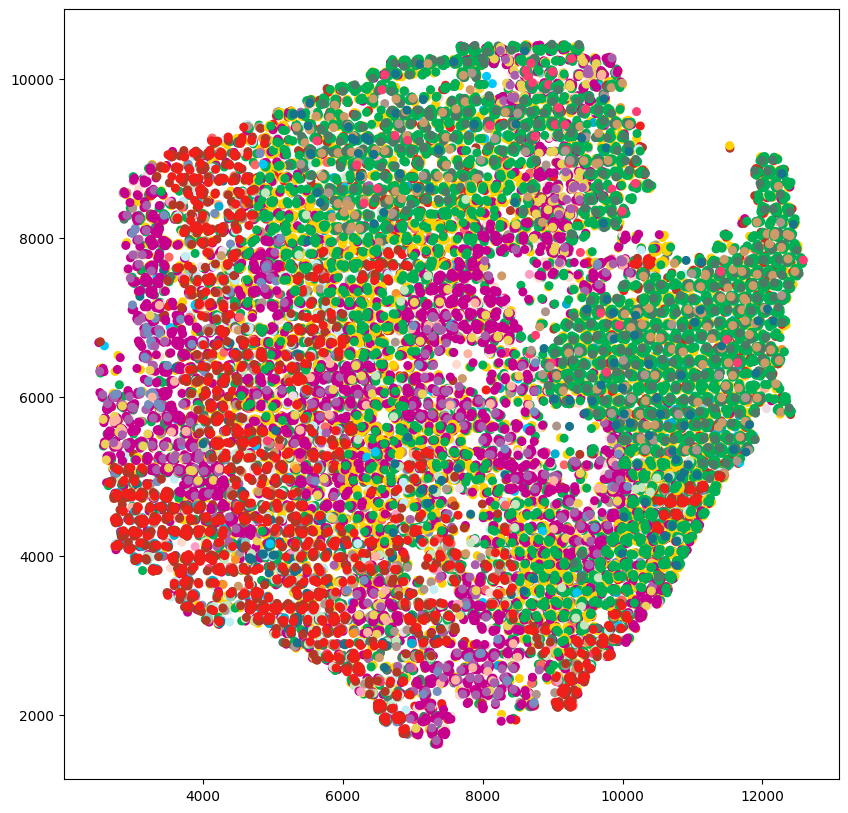

In [66]:
plt.figure(figsize=(10,10))

point_size = 30
plt.scatter(x=P77_A1_cell_center.loc[layer_1]['refine_x'],y=P77_A1_cell_center.loc[layer_1]['refine_y'],c=P77_A1_cell_center.loc[layer_1]['color'],s= point_size,alpha=1,rasterized=True)
plt.scatter(x=P77_A1_cell_center.loc[layer_2]['refine_x'],y=P77_A1_cell_center.loc[layer_2]['refine_y'],c=P77_A1_cell_center.loc[layer_2]['color'],s= point_size,alpha=1,rasterized=True)

plt.scatter(x=P77_A1_cell_center.loc[layer_3]['refine_x'],y=P77_A1_cell_center.loc[layer_3]['refine_y'],c=P77_A1_cell_center.loc[layer_3]['color'],s= point_size,alpha=1,rasterized=True)
plt.scatter(x=P77_A1_cell_center.loc[layer_4]['refine_x'],y=P77_A1_cell_center.loc[layer_4]['refine_y'],c=P77_A1_cell_center.loc[layer_4]['color'],s= point_size,alpha=1,rasterized=True)

plt.scatter(x=P77_A1_cell_center.loc[layer_5]['refine_x'],y=P77_A1_cell_center.loc[layer_5]['refine_y'],c=P77_A1_cell_center.loc[layer_5]['color'],s= point_size,alpha=1,rasterized=True)
plt.scatter(x=P77_A1_cell_center.loc[layer_6]['refine_x'],y=P77_A1_cell_center.loc[layer_6]['refine_y'],c=P77_A1_cell_center.loc[layer_6]['color'],s= point_size,alpha=1,rasterized=True)

plt.scatter(x=P77_A1_cell_center.loc[layer_7]['refine_x'],y=P77_A1_cell_center.loc[layer_7]['refine_y'],c=P77_A1_cell_center.loc[layer_7]['color'],s= point_size,alpha=1,rasterized=True)
plt.scatter(x=P77_A1_cell_center.loc[layer_8]['refine_x'],y=P77_A1_cell_center.loc[layer_8]['refine_y'],c=P77_A1_cell_center.loc[layer_8]['color'],s= point_size,alpha=1,rasterized=True)

#plt.savefig('/home/qukun/ccp1997/GBM_10X/In_depth/figure/result_1/P77_A1_spot_cell_refine.pdf',dpi = 500)
